# Sketches for Local Report
New Visualizations fro the Local Flood Report.  

**Charts:**
- time series / heatmap: all sensors, all data for each  
	Stack sensor charts above or below 311 heat map, 2 or 3 years of data  
	Highlight most recent 6 months  

- All sensors, 1 year or 6 months only of each  
	Stack over 311 data heatmap of same timespan  

- Update single sensor chart (year over year) (or leave as is)  
	Bar chart, or heat map  
	Retain single event chart below, no changes, just add some annotations  

- Add statistical statement:  
 There were X floods since neighborhood sensors were activated, and X floods in the last 6 months


## Set Up

In [25]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import geopandas as gpd
import contextily as ctx
import os

pd.set_option('display.max_columns', None)

report_folder = 'D:\WORK\FLOODNET\Local_Reports'


## Load and Prepare Data

### Sensor Data  
Sensor data is in the `Data` folder.  
Simplify data to only used columns

In [26]:
flood_data = pd.read_parquet( os.path.join( report_folder, "Data", 'all_flood_data.parquet'), engine='pyarrow' )
flood_data = flood_data[[ 'time','deployment_id','depth_proc_mm','lat','lon','sensor_display_name' ]]
flood_data = flood_data.dropna( subset=['depth_proc_mm'], axis=0 )

print( flood_data.shape[0] , 'sensor readings' )
flood_data.head(3)

9822685 sensor readings


,time,deployment_id,depth_proc_mm,lat,lon,sensor_display_name
0,2022-10-01 00:00:08.314000+00:00,easily_cosmic_slug,0.0,40.809830,-73.948100,M - 126th St/7th Av
1,2022-10-01 00:00:18.040000+00:00,handsome_violet_leech,0.0,40.695371,-73.794115,Q - 108th Ave/159th St
2,2022-10-01 00:00:19.736000+00:00,daily_happy_satyr,0.0,40.591360,-73.809960,Q - Beach 84 St


### Add CDTA information to Flood Data  
There seems to be projection problem

In [27]:
cdta = gpd.read_file( os.path.join( report_folder, 'Data', "Neighborhood_boundaries_CDTA_NTA_localrpts_3857.geojson" ) )
cdta = cdta.to_crs( 4326 )

cdta = cdta[['CDTAName','labels','geometry']].rename(columns={'labels':'CDTALabel'})
cdta['CDTALabel'] = cdta['CDTALabel'].str.strip()
cdta.head(2)

,CDTAName,CDTALabel,geometry
0,BK03 Bedford-Stuyvesant (CD 3 Approximation),Bedford-Stuyvesant West,"MULTIPOLYGON (((-73.94691 40.67839, -73.94733 ..."
1,BK13 Coney Island-Brighton Beach (CD 13 Approx...,Coney Island-Brighton Beach,"MULTIPOLYGON (((-73.95983 40.57393, -73.96022 ..."


In [28]:
def add_cdta_to_flood_data(df , cdta_boundaries ):

    if 'CDTAName' in df.columns: df = df.drop('CDTAName', axis=1)
    if 'CDTALabel' in df.columns: df = df.drop('CDTALabel', axis=1)

    # extract unique sensors so that we are not matching 1M records
    unique_Sensors = df.groupby('deployment_id').agg({
        'lat':'first',
        'lon':'first'
    })

    # Create a GeoDataFrame from the unique sensors and convert to NY State Plane
    geo_sensors = gpd.GeoDataFrame(unique_Sensors, geometry=gpd.points_from_xy(unique_Sensors.lon, unique_Sensors.lat), crs=4326 )

    # Spatial join the sensors to the CDTA polygons
    geo_sensors = geo_sensors.sjoin(cdta_boundaries[['CDTAName','CDTALabel','geometry']]).drop(['index_right','geometry','lat','lon'], axis=1)

    # Join to the flood data
    return  df.join(geo_sensors, on='deployment_id')

flood_data = add_cdta_to_flood_data( flood_data , cdta )
flood_data.head(3)

,time,deployment_id,depth_proc_mm,lat,lon,sensor_display_name,CDTAName,CDTALabel
0,2022-10-01 00:00:08.314000+00:00,easily_cosmic_slug,0.0,40.809830,-73.948100,M - 126th St/7th Av,MN10 Harlem (CD 10 Equivalent),Harlem
1,2022-10-01 00:00:18.040000+00:00,handsome_violet_leech,0.0,40.695371,-73.794115,Q - 108th Ave/159th St,QN12 Jamaica-St. Albans-Hollis (CD 12 Approxim...,South Jamaica
2,2022-10-01 00:00:19.736000+00:00,daily_happy_satyr,0.0,40.591360,-73.809960,Q - Beach 84 St,QN14 The Rockaways (CD 14 Approximation),Rockaway Beach-Arverne-Edgemere


### Remove Non-Flood Events

In [29]:
events = pd.read_excel( os.path.join(report_folder, 'Data', 'EventsData.xlsx'), sheet_name='All Events till 052023')

def cleanup_events( df ):
    df = df[ df['Deployment_id'] != 'ugliest_cyan_elephant' ] # sensor on the water way 
    df = df[ df['Class'] == 0 ].copy() # 0 is the code for floods

    df['Start_time'] = pd.to_datetime(df['Start_time'])
    df['End_time'] = pd.to_datetime(df['End_time'])

    # drop NaT values and create Intervals
    df = df.dropna(subset=['Start_time','End_time'])
    df['Interval'] =  df.apply( lambda x: pd.Interval(x['Start_time'],x['End_time'],closed='both'),axis=1) 

    df = df.drop(['Borough','Type', 'Deployment_Date','Latitude','Longitude','Address'], axis=1)
    df = df.drop( df.columns[df.columns.str.contains('Unnamed')] ,axis=1) 
    return df

events = cleanup_events(events)
events.head()

,Deployment_id,Start_time,End_time,Duration,Minutes,Class,Interval
0,asleep_apricot_bedbug,2022-09-13 08:25:28,2022-09-13 08:46:44,00:21:16,21.266667,0,"[2022-09-13 08:25:28, 2022-09-13 08:46:44]"
25,big_pink_elephant,2023-03-31 09:49:44,2023-03-31 10:02:27,00:12:43,12.716667,0,"[2023-03-31 09:49:44, 2023-03-31 10:02:27]"
34,big_pink_elephant,2023-04-23 03:19:43,2023-04-23 03:46:06,00:26:23,26.383333,0,"[2023-04-23 03:19:43, 2023-04-23 03:46:06]"
35,big_pink_elephant,2023-04-30 21:24:03,2023-05-01 01:58:11,04:34:08,274.133333,0,"[2023-04-30 21:24:03, 2023-05-01 01:58:11]"
125,blue_eyed_tiger,2023-04-30 21:22:03,2023-04-30 21:36:02,00:13:59,13.983333,0,"[2023-04-30 21:22:03, 2023-04-30 21:36:02]"


In [30]:
def remove_non_flood_events(df_flood, df_events):
   """
   This function assigns 0 to depths that are not during a flood event.
   + converts the depth to inches
   time is in UTC for both dataframes
   Takes a while to run
   """
   
   df_flood['time'] = df_flood['time'].dt.tz_localize(None)
   df_flood['During Flood'] = False
   print( df_events.shape[0] , 'events will be tested' )

   count = 0
   matching_floods = pd.DataFrame()
   for sensor_id in df_flood['deployment_id'].unique():
      t_event = df_events[ (df_events['Deployment_id'] == sensor_id) ]
      t_flood = df_flood[ df_flood['deployment_id'] == sensor_id ].copy()

      for event_interval,sensor_id in zip(t_event['Interval'].values,t_event['Deployment_id'].values ):
         t_flood.loc[ 
            (t_flood['time'].between( event_interval.left, event_interval.right)) & 
            (t_flood['deployment_id'] == sensor_id) , 
            'During Flood'
            ] = True

      matching_floods = pd.concat([matching_floods, t_flood ])

   matching_floods['clean_depth'] = np.where( matching_floods['During Flood'] == True , matching_floods['depth_proc_mm'] , 0 )
   matching_floods['clean_depth_in'] = matching_floods['clean_depth'] / 25.4
   return matching_floods

flood_data = remove_non_flood_events(flood_data, events)
flood_data[ flood_data['During Flood'] == True ].head()

310 events will be tested


,time,deployment_id,depth_proc_mm,lat,lon,sensor_display_name,CDTAName,CDTALabel,During Flood,clean_depth,clean_depth_in
342762,2022-09-19 01:41:29.724,easily_cosmic_slug,0.0,40.80983,-73.9481,M - 126th St/7th Av,MN10 Harlem (CD 10 Equivalent),Harlem,True,0.0,0.000000
342779,2022-09-19 01:42:32.401,easily_cosmic_slug,17.0,40.80983,-73.9481,M - 126th St/7th Av,MN10 Harlem (CD 10 Equivalent),Harlem,True,17.0,0.669291
342791,2022-09-19 01:43:35.263,easily_cosmic_slug,18.0,40.80983,-73.9481,M - 126th St/7th Av,MN10 Harlem (CD 10 Equivalent),Harlem,True,18.0,0.708661
342806,2022-09-19 01:44:38.647,easily_cosmic_slug,17.0,40.80983,-73.9481,M - 126th St/7th Av,MN10 Harlem (CD 10 Equivalent),Harlem,True,17.0,0.669291
342819,2022-09-19 01:45:41.250,easily_cosmic_slug,16.0,40.80983,-73.9481,M - 126th St/7th Av,MN10 Harlem (CD 10 Equivalent),Harlem,True,16.0,0.629921


### Convert Data to NYC time from UTC

In [31]:
# Make filtered data time UTC then convert to America/New_York
flood_data['time_NY'] = flood_data['time'].dt.tz_localize('UTC').dt.tz_convert('America/New_York')
display(flood_data.head(3))

,time,deployment_id,depth_proc_mm,lat,lon,sensor_display_name,CDTAName,CDTALabel,During Flood,clean_depth,clean_depth_in,time_NY
0,2022-10-01 00:00:08.314,easily_cosmic_slug,0.0,40.80983,-73.9481,M - 126th St/7th Av,MN10 Harlem (CD 10 Equivalent),Harlem,False,0.0,0.0,2022-09-30 20:00:08.314000-04:00
16,2022-10-01 00:01:11.458,easily_cosmic_slug,0.0,40.80983,-73.9481,M - 126th St/7th Av,MN10 Harlem (CD 10 Equivalent),Harlem,False,0.0,0.0,2022-09-30 20:01:11.458000-04:00
38,2022-10-01 00:02:13.998,easily_cosmic_slug,0.0,40.80983,-73.9481,M - 126th St/7th Av,MN10 Harlem (CD 10 Equivalent),Harlem,False,0.0,0.0,2022-09-30 20:02:13.998000-04:00


## PLOTS  
All plots will be generated here and will be saved in a PNG file in the `Charts` folder.

In [32]:
[i for i in flood_data['CDTALabel'].unique()]

['Harlem',
 'South Jamaica',
 'Rockaway Beach-Arverne-Edgemere',
 'Morningside Heights-Hamilton Heights',
 'Westerleigh-Castleton Corners',
 'Park Slope-Carroll Gardens',
 'Morrisania-Crotona Park East',
 'Howard Beach-Lindenwood',
 'Soundview',
 'New Springville-Willowbrook-Bulls Head-Travis',
 'Bedford-Stuyvesant West',
 'Greenwich Village-SoHo',
 'Williamsburg-Greenpoint',
 'North Shore',
 'Mid-Island']

In [33]:
cd_name = 'Park Slope-Carroll Gardens'
local_data = flood_data[ flood_data['CDTALabel'] == cd_name ].copy()

local_cdta = cdta[cdta['CDTALabel'] == cd_name ].to_crs(3857)

local_data.head(3)

,time,deployment_id,depth_proc_mm,lat,lon,sensor_display_name,CDTAName,CDTALabel,During Flood,clean_depth,clean_depth_in,time_NY
5,2022-10-01 00:00:37.191,jolly_tender_squid,0.0,40.675734,-74.003396,BK - Henry St/Mill St,BK06 Park Slope-Carroll Gardens (CD 6 Approxim...,Park Slope-Carroll Gardens,False,0.0,0.0,2022-09-30 20:00:37.191000-04:00
28,2022-10-01 00:01:40.368,jolly_tender_squid,0.0,40.675734,-74.003396,BK - Henry St/Mill St,BK06 Park Slope-Carroll Gardens (CD 6 Approxim...,Park Slope-Carroll Gardens,False,0.0,0.0,2022-09-30 20:01:40.368000-04:00
47,2022-10-01 00:02:43.190,jolly_tender_squid,0.0,40.675734,-74.003396,BK - Henry St/Mill St,BK06 Park Slope-Carroll Gardens (CD 6 Approxim...,Park Slope-Carroll Gardens,False,0.0,0.0,2022-09-30 20:02:43.190000-04:00


### 311 Complaints Data

In [34]:
polygon = local_cdta \
                .dissolve() \
                .to_crs(4326) \
                # .geometry.values[0]


polygon1 = polygon.copy()
polygon1.geometry = polygon1.geometry.simplify(0.001).buffer( 0.002 ).simplify(0.001)



C:\Users\cansu\AppData\Local\Temp\ipykernel_25580\2130636024.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polygon1.geometry = polygon1.geometry.simplify(0.001).buffer( 0.002 ).simplify(0.001)


In [35]:

import requests
data_311 = None
data_query = 'https://data.cityofnewyork.us/resource/erm2-nwe9.json'
# Add more descriptors here
descriptors = ['Street Flooding (SJ)','Catch Basin Clogged/Flooding (Use Comments) (SC)', 'Manhole Overflow (Use Comments) (SA1)' ]
descriptors_filter = ' OR '.join([f"descriptor='{d}'" for d in descriptors])
selectors = 'unique_key,created_date,agency,complaint_type,descriptor,status,latitude,longitude'

start_date = ( pd.Timestamp.today() - pd.Timedelta(days=360*3))
# start_date to the beginning of the year
start_date = start_date.replace(month=1,day=1).date().strftime('%Y-%m-%d')

polygon = local_cdta \
                .dissolve() \
                .to_crs(4326) \
                .geometry.values[0]

polygon = local_cdta \
                .dissolve() \
                .to_crs(4326) \

polygon1 = polygon.copy()
polygon1.geometry = polygon1.geometry.simplify(0.001).to_crs(2263).buffer( 1000 ).to_crs(4326).simplify(0.001)

polygon_geom = polygon1.geometry.values[0]

url = f"{data_query}?$where=within_polygon(location, '{polygon_geom}') AND created_date>'{start_date}' AND ({descriptors_filter})&$select={selectors}&$limit=5000"
print( url )
response = requests.get(url)
if response.status_code != 200:
    print(f"Error {response.status_code}")
else:
    data_311 = pd.DataFrame( response.json() )

data_311

https://data.cityofnewyork.us/resource/erm2-nwe9.json?$where=within_polygon(location, 'POLYGON ((-74.02272717024867 40.67885077096593, -74.02180546885106 40.68160753956802, -74.00853804331172 40.68825237113256, -74.00442084996712 40.69427479466645, -74.00128934238364 40.69528204013543, -73.99011300521367 40.69183424577071, -73.98907551457907 40.688543347857085, -73.98119110837143 40.68618738127122, -73.97730994594271 40.687543634420244, -73.97141353075497 40.68513243741126, -73.97015975599633 40.68291170367684, -73.97160653552153 40.67956848023093, -73.96671764366698 40.677653810625415, -73.96518251790042 40.67307163328159, -73.97870608229167 40.658594564165384, -73.99090441198553 40.663162349897505, -73.99442687045203 40.66306897333195, -73.99808549637278 40.666555413137615, -74.00573075113213 40.663422857226045, -74.01617999918065 40.66184292636397, -74.02135165102548 40.665092450811336, -74.02353022992916 40.676768293154474, -74.02272717024867 40.67885077096593))') AND created_date>

,unique_key,created_date,agency,complaint_type,descriptor,status,latitude,longitude
0,58468621,2023-08-10T08:23:00.000,DEP,Sewer,Catch Basin Clogged/Flooding (Use Comments) (SC),Open,40.67910863109049,-73.97471226953448
1,58444902,2023-08-08T14:26:00.000,DEP,Sewer,Street Flooding (SJ),Closed,40.68132335048843,-74.00893067976263
2,58452672,2023-08-08T14:23:00.000,DEP,Sewer,Catch Basin Clogged/Flooding (Use Comments) (SC),Closed,40.68132335048843,-74.00893067976263
3,58379480,2023-08-01T16:41:00.000,DEP,Sewer,Catch Basin Clogged/Flooding (Use Comments) (SC),Closed,40.67606745545129,-73.99985579368702
4,58361134,2023-07-30T19:59:00.000,DEP,Sewer,Catch Basin Clogged/Flooding (Use Comments) (SC),Closed,40.682824904196806,-74.00649715272053
...,...,...,...,...,...,...,...,...
708,45380123,2020-01-13T21:38:00.000,DEP,Sewer,Manhole Overflow (Use Comments) (SA1),Closed,40.69184697077848,-73.99359572442289
709,45373514,2020-01-12T08:56:00.000,DEP,Sewer,Catch Basin Clogged/Flooding (Use Comments) (SC),Closed,40.68424273042894,-73.98202247922302
710,45333251,2020-01-07T15:01:00.000,DEP,Sewer,Street Flooding (SJ),Closed,40.678813753514305,-73.96979113801875
711,45327150,2020-01-06T09:06:00.000,DEP,Sewer,Catch Basin Clogged/Flooding (Use Comments) (SC),Closed,40.66906054648242,-73.97728989146187


### Combine All sensors and 311 Data

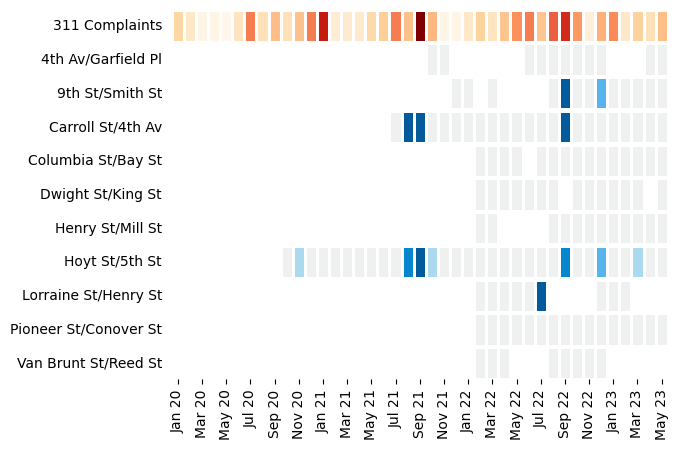

In [36]:
# remove UTC info from time_NY column
import matplotlib.dates as mdates
f = '1M'

time_min = local_data['time_NY'].max() - pd.Timedelta( weeks = 6*4 )
local_data['time_NY'] = local_data['time_NY'].dt.tz_localize(None)

filtered_data = local_data.copy()
sensors_over_time = local_data.groupby( ['sensor_display_name', pd.Grouper(key='time_NY', freq=f)] ).agg({'clean_depth_in':'max'}).reset_index()
sensors_over_time = sensors_over_time[ ~sensors_over_time['sensor_display_name'].str.contains('RET')]

pt = pd.pivot_table(
    sensors_over_time,
    index='sensor_display_name',
    columns='time_NY',
    values='clean_depth_in',
)

data_311['created_date'] = pd.to_datetime(data_311['created_date'])
filtered_311 = data_311[ data_311['created_date'] < local_data['time_NY'].max() ]

monthly_311 = filtered_311.groupby( pd.Grouper(key='created_date', freq=f) ).agg({'unique_key':'nunique'}).reset_index().rename(columns={'unique_key':'count'})
monthly_311['ind'] = '311 Complaints'
monthly_311 = monthly_311.pivot( index='ind', columns='created_date', values='count' )

joined_data = pd.concat( [monthly_311,pt] )

joined_data.index = [i.split(' - ')[1] if '-' in i else i for i in joined_data.index ]

# Segmented Color Map
def make_Ramp( ramp_colors ): 
    from colour import Color
    # from matplotlib.colors import LinearSegmentedColormap
    from matplotlib.colors import ListedColormap, LinearSegmentedColormap

    color_ramp = ListedColormap( ramp_colors )
    return color_ramp

custom_ramp = make_Ramp( ['#EFF0F0',"#ABDAEF","#58B4ED", '#0586CE', '#045B9B'] ) 
values = ['No Flood', 'Minimal Flooding', 'Minor Flood', 'Moderate Flooding', 'Major Flooding']

fig, axs = plt.subplots( nrows = joined_data.shape[0] )
for count,(i, r) in enumerate(joined_data.iterrows()):
    
    ax = axs[count]

    sns.heatmap(
        r.to_frame().T,
        ax=ax,
        cmap= custom_ramp if not '311' in i else 'OrRd',
        cbar=False,
        lw=1,
        linecolor='w'
    )

    # rotate y_ticks 0
    ax.set_yticklabels( ax.get_yticklabels(), rotation=0 )
    ax.tick_params( axis='y', left=False )

    if count != joined_data.shape[0]-1:
        ax.tick_params( axis='x', which='both', bottom=False, top=False, labelbottom=False )
        
    else:
        # x-ticks in %b %Y format
        # get_xticklabels() then convert
        xticklabels = [ pd.to_datetime(x.get_text()).strftime('%b %y') for x in ax.get_xticklabels() ]
        ax.set_xticklabels( xticklabels )

plt.subplots_adjust( hspace=0.05 )


2022-12-14 19:59:55.822000


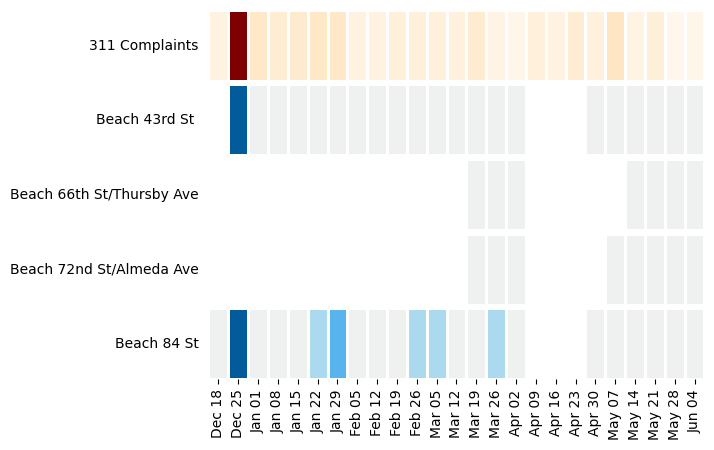

In [13]:
# remove UTC info from time_NY column
import matplotlib.dates as mdates
f = '1W'

time_min = local_data['time_NY'].max() - pd.Timedelta( weeks = 6*4 )
print( time_min )

filtered_local_data = local_data.copy()
filtered_local_data['time_NY'] = local_data['time_NY'].dt.tz_localize(None)
filtered_local_data = local_data[ local_data['time_NY'] > time_min ]

sensors_over_time = filtered_local_data.groupby( ['sensor_display_name', pd.Grouper(key='time_NY', freq=f)] ).agg({'clean_depth_in':'max'}).reset_index()
sensors_over_time = sensors_over_time[ ~sensors_over_time['sensor_display_name'].str.contains('RET')]

pt = pd.pivot_table(
    sensors_over_time,
    index='sensor_display_name',
    columns='time_NY',
    values='clean_depth_in',
)

data_311['created_date'] = pd.to_datetime(data_311['created_date'])
filtered_311 = data_311[ data_311['created_date'] < local_data['time_NY'].max() ]
filtered_311 = filtered_311[ filtered_311['created_date'] > time_min ]

monthly_311 = filtered_311.groupby( pd.Grouper(key='created_date', freq=f) ).agg({'unique_key':'nunique'}).reset_index().rename(columns={'unique_key':'count'})
monthly_311['ind'] = '311 Complaints'
monthly_311 = monthly_311.pivot( index='ind', columns='created_date', values='count' )

joined_data = pd.concat( [monthly_311,pt] )

joined_data.index = [i.split(' - ')[1] if '-' in i else i for i in joined_data.index ]

# Segmented Color Map
def make_Ramp( ramp_colors ): 
    from colour import Color
    # from matplotlib.colors import LinearSegmentedColormap
    from matplotlib.colors import ListedColormap, LinearSegmentedColormap

    color_ramp = ListedColormap( ramp_colors )
    return color_ramp

custom_ramp = make_Ramp( ['#EFF0F0',"#ABDAEF","#58B4ED", '#0586CE', '#045B9B'] ) 
values = ['No Flood', 'Minimal Flooding', 'Minor Flood', 'Moderate Flooding', 'Major Flooding']

fig, axs = plt.subplots( nrows = joined_data.shape[0] )
for count,(i, r) in enumerate(joined_data.iterrows()):
    
    ax = axs[count]

    sns.heatmap(
        r.to_frame().T,
        ax=ax,
        cmap= custom_ramp if not '311' in i else 'OrRd',
        cbar=False,
        lw=1,
        linecolor='w'
    )

    # rotate y_ticks 0
    ax.set_yticklabels( ax.get_yticklabels(), rotation=0 )
    ax.tick_params( axis='y', left=False )

    if count != joined_data.shape[0]-1:
        ax.tick_params( axis='x', which='both', bottom=False, top=False, labelbottom=False )
        
    else:
        # x-ticks in %b %Y format
        # get_xticklabels() then convert
        xticklabels = [ pd.to_datetime(x.get_text()).strftime('%b %d') for x in ax.get_xticklabels() ]
        ax.set_xticklabels( xticklabels )

plt.subplots_adjust( hspace=0.05 )


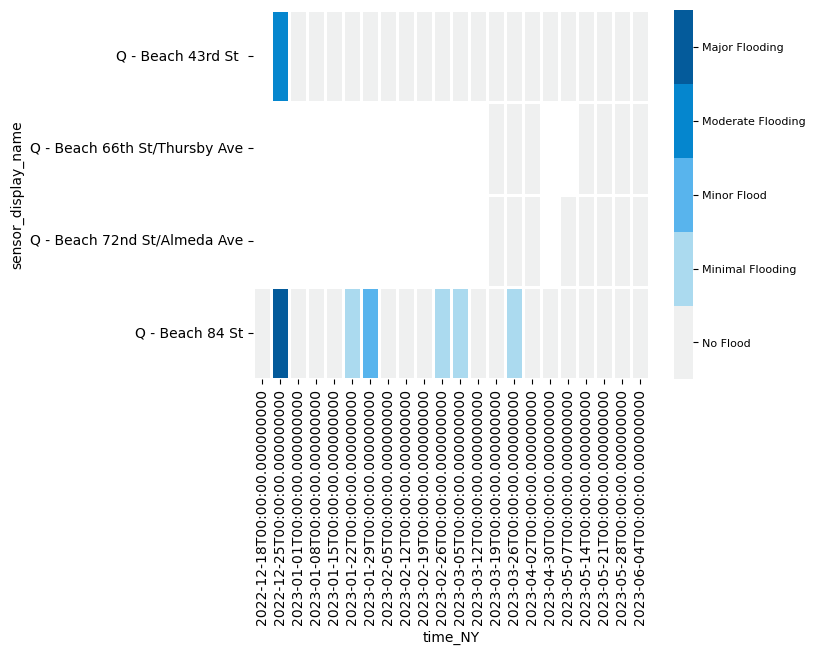

In [14]:

ax = sns.heatmap(
    pt,
    cmap= custom_ramp,
    lw=1,
    linecolor='w',
    cbar=True
)

values = ['No Flood', 'Minimal Flooding', 'Minor Flood', 'Moderate Flooding', 'Major Flooding']

# Simplify the colors bar
n = len(values)
colorbar = ax.collections[0].colorbar 

r = colorbar.vmax - colorbar.vmin 
colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
colorbar.set_ticklabels( values )
colorbar.ax.tick_params(labelsize=8) 

plt.show()

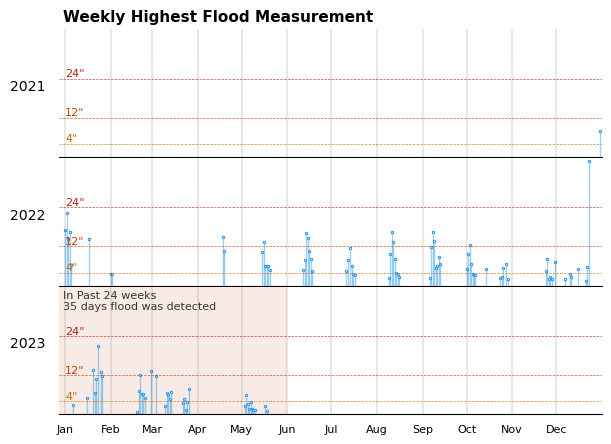

In [15]:
from matplotlib.ticker import MultipleLocator

filtered_data = local_data.dropna( subset=['sensor_display_name'] ,axis=0 )

single_sensor = filtered_data[ filtered_data['sensor_display_name'].str.contains('84') ]

f = '1D'
single_sensor_1h = single_sensor.groupby(pd.Grouper(key='time_NY', freq=f)).agg({'clean_depth_in':'max'}).reset_index()

single_sensor_1h['date'] = single_sensor_1h['time_NY'].dt.date
single_sensor_1h['hour'] = single_sensor_1h['time_NY'].dt.hour
single_sensor_1h['year'] = single_sensor_1h['time_NY'].dt.year

single_sensor_1h['flat_date'] = single_sensor_1h['time_NY'].dt.strftime('1900-%m-%d %H:%M:%S')
single_sensor_1h['flat_date'] = pd.to_datetime( single_sensor_1h['flat_date'] )
single_sensor_1h['flat_date_end'] = single_sensor_1h['flat_date'] + pd.Timedelta( f )

grid_colors = ['#ca6702','#bb3e03','#ae2012']
values = ['Minor Flood', 'Moderate Flood', 'Major Flood']


fig,axs = plt.subplots( nrows = single_sensor_1h[single_sensor_1h['clean_depth_in'] > 0]['year'].nunique() , sharex=True, sharey=True, figsize = (7,5) )

for i,year in enumerate( single_sensor_1h[single_sensor_1h['clean_depth_in'] > 0]['year'].unique() ):
    ax = axs[i]
    single_sensor_1h_year = single_sensor_1h[ single_sensor_1h['year'] == year ]

    ax.vlines( ymax=single_sensor_1h_year['clean_depth_in'], ymin=0, x=single_sensor_1h_year['flat_date'], alpha=0.5, lw=1, color='#39a2ea' )

    single_sensor_1h_year_above = single_sensor_1h_year[ single_sensor_1h_year['clean_depth_in'] > 0 ]
    ax.scatter( y=single_sensor_1h_year_above['clean_depth_in'], x=single_sensor_1h_year_above['flat_date'], s=3, marker='o', lw=0.7 ,fc='w' ,ec='#2093f2' )
    # ax.plot( single_sensor_1h_year['flat_date'], single_sensor_1h_year['clean_depth_in'], lw=1, color='#2093f2')

    ax.set_ylim( 0, single_sensor_1h['clean_depth_in'].max() + 1 )
    ax.set_ylabel( year, rotation=0 , labelpad=10, fontsize=10, ha='right' )
    sns.despine( ax=ax, left=True )

    # format y-axis as %b %d
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    # every month
    ax.xaxis.set_major_locator(mdates.MonthLocator())

    ax.set_xlim( pd.to_datetime('28-12-1899 00:00:00') , pd.to_datetime('31-12-1900 23:59:59') )
    ax.tick_params(axis='y', which='both', left=False, labelleft=False , labelrotation=0 )
    ax.tick_params( axis='x' , labelsize=8, bottom=False )

    [ ax.axhline(t, ls='--', lw=0.5, alpha=0.8, color=grid_colors[n]) for n,t in enumerate([4,12,24]) ]
    [ ax.annotate(f'{t}"', xy=( pd.to_datetime('01-01-1900'),t) ,color=grid_colors[n], va='bottom', ha='left', fontsize=8 ) for n,t in enumerate([4,12,24]) ]

    [ ax.axvline( pd.to_datetime( f'{i}-01-1900' ), color="#333", lw=0.2, alpha=0.8 ) for i in range(1,13)]

    if year == max(single_sensor_1h['year'].unique()):
        #change year to 1900
        today = pd.to_datetime( single_sensor['time_NY'].max().round('1d').strftime('1900-%m-%d') )
        past = today - pd.Timedelta(weeks=24)

        # filter data by 6 months
        single_sensor_1h_past = single_sensor_1h[ (single_sensor_1h['flat_date'] >= past) & (single_sensor_1h['flat_date'] <= today) ]
        single_sensor_1h_past_above = single_sensor_1h_past[ single_sensor_1h_past['clean_depth_in'] > 4 ]
        #count number of days with flood
        single_sensor_1h_past_above['time_NY'].nunique()

        ax.axvspan( xmin=past, xmax = today, ec='none', fc = '#bb3e03', zorder = 0, alpha=0.1 )
        ax.annotate( f'In Past 24 weeks\n{ single_sensor_1h_past_above["time_NY"].nunique() } days flood was detected', xy=(past + pd.Timedelta(weeks=2.2), single_sensor['clean_depth_in'].max()), va='top',ha='left', fontsize=8 , color='#333', zorder=5 )

plt.suptitle( 'Weekly Highest Flood Measurement' , fontsize=11, fontweight='bold', y=0.92, x=0.13, ha='left' )
plt.subplots_adjust( hspace=0.01 )

In [16]:
import requests
url = 'https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?begin_date=20221220&end_date=20221230&station=8518750&product=water_level&datum=MLLW&time_zone=gmt&units=english&application=DataAPI_Sample&format=json'
r = requests.get(url)
data = r.json()['data']
tidal = pd.DataFrame( data )
tidal['t'] = pd.to_datetime(tidal['t']).dt.tz_localize('utc').dt.tz_convert('US/Eastern').dt.tz_localize(None)
tidal = tidal.set_index('t').drop(['q','f'],axis=1).astype(float)
tidal.head()

,v,s
t,,
2022-12-19 19:00:00,2.789,0.112
2022-12-19 19:06:00,2.720,0.177
2022-12-19 19:12:00,2.612,0.102
2022-12-19 19:18:00,2.513,0.272
2022-12-19 19:24:00,2.418,0.249


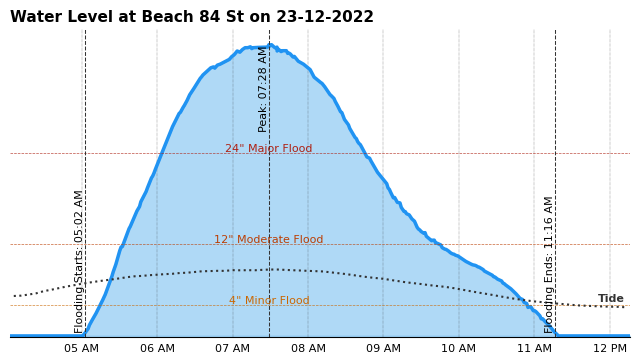

In [24]:
start_date = pd.to_datetime( '2022-12-23 03:00:00' )
end_date = pd.to_datetime( '2022-12-23 15:00:00' )

filtered_data = single_sensor[ (single_sensor['time_NY'] >= start_date) & (single_sensor['time_NY'] <= end_date) ]

start_date = filtered_data[ filtered_data['clean_depth_in'] > 0 ]['time_NY'].min() - pd.Timedelta(hours=1)
end_date = filtered_data[ filtered_data['clean_depth_in'] > 0 ]['time_NY'].max() + pd.Timedelta(hours=1)

filtered_data = single_sensor[ (single_sensor['time_NY'] >= start_date) & (single_sensor['time_NY'] <= end_date) ]

plt.figure( figsize=(8,4) )
plt.plot( filtered_data['time_NY'] , filtered_data['clean_depth_in'], lw=2.5, color='#2093f2' )
plt.fill_between( filtered_data['time_NY'] , filtered_data['clean_depth_in'], color="#39a2ea", alpha=0.4)

first_flood = filtered_data[ filtered_data['clean_depth_in'] > 0 ]['time_NY'].min()
last_flood = filtered_data[ filtered_data['clean_depth_in'] > 0 ]['time_NY'].max()
max_flood = filtered_data.sort_values( by = 'clean_depth_in' , ascending = False ).iloc[0]['time_NY']

ax = plt.gca()
grid_colors = ['#ca6702','#bb3e03','#ae2012']
values = ['Minor Flood', 'Moderate Flood', 'Major Flood']

[ ax.axhline(t, ls='--', lw=0.5, alpha=0.8, color=grid_colors[n]) for n,t in enumerate([4,12,24]) ]
[ ax.annotate(f'{t}" {values[n]}', xy=( max_flood,t) ,color=grid_colors[n], va='bottom', ha='center', fontsize=8 ) for n,t in enumerate([4,12,24]) ]

ax.grid(axis='x', color='#333', lw=0.35, ls=":")

ax.tick_params(axis='y', left=False, labelleft=False )

plt.axvline( x = first_flood , color = '#333', ls='--', lw=0.75 )
plt.axvline( x = last_flood , color = '#333' , ls='--', lw=0.75)
plt.axvline( x = max_flood , color = '#333' , ls='--', lw=0.75 )

plt.annotate( f'Flooding Starts: {first_flood.time().strftime("%H:%M %p")}' , ( first_flood , filtered_data[filtered_data["time_NY"]==first_flood]["clean_depth_in"].values[0] ) , rotation=90 , va='bottom', ha='right' , fontsize=8)
plt.annotate( f'Flooding Ends: {last_flood.time().strftime("%H:%M %p")}' , ( last_flood , filtered_data[filtered_data["time_NY"]==last_flood]["clean_depth_in"].values[0] ) , rotation=90 , va='bottom', ha='right' , fontsize=8)
plt.annotate( f'Peak: {max_flood.time().strftime("%H:%M %p")}' , ( max_flood , filtered_data[filtered_data["time_NY"]==max_flood]["clean_depth_in"].values[0] ) , rotation=90 , va='top', ha='right' , fontsize=8)
sns.despine(left=True)

#x-ticks in dd-mm-yyyy format every hour
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%I %p'))

ax.tick_params( axis='x', labelsize=8, pad=0.5, bottom=False )

ax = plt.gca()

filtered_tidal = tidal[ (tidal.index >= start_date) & (tidal.index <= end_date) ]
ax.plot( filtered_tidal.index, filtered_tidal['v'] , color = '#333', ls=":" )

final_tidal_points = filtered_tidal.reset_index().iloc[-1]
ax.annotate( f'Tide' , ( final_tidal_points.t , final_tidal_points.v+0.5 ) , rotation=0 , va='bottom', ha='right' , fontsize=8, color='#333', fontweight='bold' )

ax.set_xlim( start_date , end_date )
ax.set_ylim( -0.2 , filtered_data['clean_depth_in'].max() + 2 )
ax.set_title( f'Water Level at { single_sensor["sensor_display_name"].values[0].split(" - ")[1] } on {start_date.strftime("%d-%m-%Y")}' , fontsize=11 , fontweight='bold', loc='left' );